# A Simple Model

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_STATE = 42

## Functions

### for Feature Engineering

In [3]:
# Constant
drop_cols = ["Name", "SibSp", "Parch", "Ticket"]
obj_col = "Survived"
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

## feature engineering
def feature_engineering(raw_df):
    df = raw_df.copy()
    df["Cabin"] = df["Cabin"].apply(lambda x: x[:1] if x is not np.nan else np.nan)
    df["Ticket"] = df["Ticket"].apply(lambda x: str(x).split()[0])
    df["Family"] = df["SibSp"] + df["Parch"]
    return df

In [4]:
# cat
def to_category(train_df, test_df):
    cat = ["Sex", "Cabin", "Embarked"]
    mappings = {}
    for col in cat:
        le = preprocessing.LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return train_df, test_df, mappings

In [5]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions  = 1*(y_proba >= t)
    return y_proba, predictions

### for  Metrics and Plots

In [6]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

In [7]:
def get_metrics_noproba(y, ypred):
    return {
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [8]:
def get_plots_noproba(y, ypred):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    return {
        'cm': cm_plot
    }

In [9]:
def get_metrics(y, ypred, yproba):
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [10]:
def get_plots(y, ypred, yproba):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall)
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [11]:
# evaluation
def eval_model(clf, X, y):
    y_proba, y_pred = get_predictions(clf, X)
    metrics =  get_metrics(y, y_pred, y_proba)
    plots = get_plots(y, y_pred, y_proba)
    return metrics, plots

## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation. 

Here are the features in the data:

```
survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

In [12]:
print("Loading data...")
df_train = pd.read_csv(train_df_path, index_col="PassengerId")
df_test = pd.read_csv(test_df_path, index_col="PassengerId")

Loading data...


### Some EDA

In [13]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


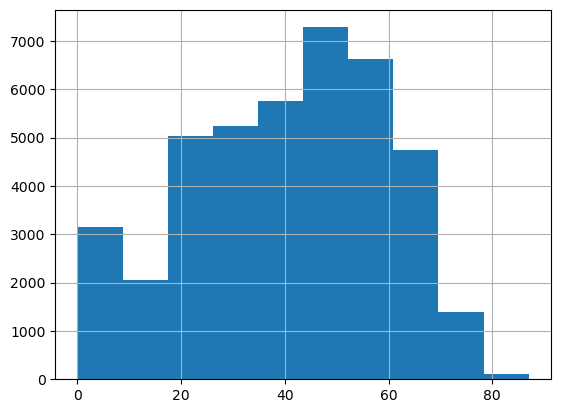

In [14]:
df_train[df_train.Survived==1].Age.hist()
plt.show()

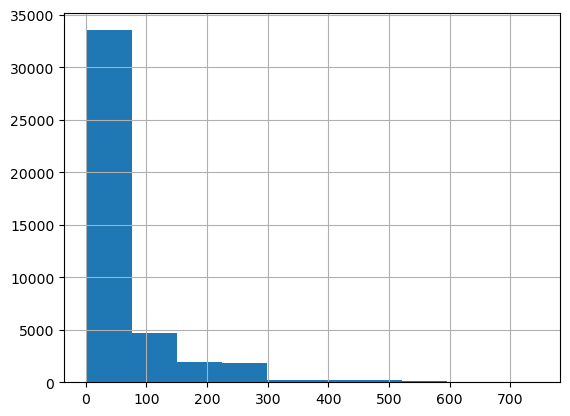

In [16]:
df_train[df_train.Survived==1].Fare.hist()
plt.show()

In [17]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


### Feature Engineering

In [18]:
print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
train_df, test_df, mappings = to_category(train_df, test_df)

Engineering features...


In [19]:
mappings

{'Sex': {'female': 0, 'male': 1},
 'Cabin': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'T': 7,
  nan: 8},
 'Embarked': {'C': 0, 'Q': 1, 'S': 2, nan: 3}}

### Value Imputation

In [20]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [21]:
train_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,
0,1,1,0.00,27.14,2,2,2
1,3,1,0.00,13.35,8,2,0
2,3,1,0.33,71.29,8,2,3
3,3,1,19.00,13.04,8,2,0
4,3,1,25.00,7.76,8,2,0


In [22]:
train_df.describe()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
count,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.106910,0.56114,37.09281,43.870465,5.983550,1.504520,0.852250
std,0.837727,0.49625,19.26607,69.560745,3.023404,0.835899,1.412792
min,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.00000,24.00000,10.020000,2.000000,1.000000,0.000000
50%,2.000000,1.00000,38.00000,24.440000,8.000000,2.000000,0.000000
75%,3.000000,1.00000,53.00000,33.470000,8.000000,2.000000,1.000000
max,3.000000,1.00000,87.00000,744.660000,8.000000,3.000000,17.000000


In [23]:
for col in ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Family']:
    print(col, train_df[col].unique())

Pclass [1 3 2]
Sex [1 0]
Cabin [2 8 0 3 1 4 5 6 7]
Embarked [2 0 1 3]
Family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


### Train-Validation Split

In [24]:
print("Training model...")
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

Training model...


## Model Training

### Very Baseline Model

In [25]:
np.mean(y_train), np.mean(y_valid)

(0.42774626865671644, 0.42772727272727273)

Everyone Dies

In [26]:
metrics_train_alldie = get_metrics_noproba(y_train, np.ones(y_train.size))
metrics_valid_alldie = get_metrics_noproba(y_valid, np.ones(y_valid.size))
print("TRAIN/ALLDIE", metrics_train_alldie)
print("VALID/ALLDIE", metrics_valid_alldie)

TRAIN/ALLDIE {'accuracy': 0.42774626865671644, 'precision': 0.42774626865671644, 'recall': 1.0, 'f1': 0.5991908759238546, 'cm': array([[    0, 38341],
       [    0, 28659]])}
VALID/ALLDIE {'accuracy': 0.42772727272727273, 'precision': 0.42772727272727273, 'recall': 1.0, 'f1': 0.5991722381407195, 'cm': array([[    0, 18885],
       [    0, 14115]])}


In [27]:
metrics_train_nonedie = get_metrics_noproba(y_train, np.zeros(y_train.size))
metrics_valid_nonedie = get_metrics_noproba(y_valid, np.zeros(y_valid.size))
print("TRAIN/NONEDIE", metrics_train_nonedie)
print("VALID/NONEDIE", metrics_valid_nonedie)

TRAIN/NONEDIE {'accuracy': 0.5722537313432836, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'cm': array([[38341,     0],
       [28659,     0]])}
VALID/NONEDIE {'accuracy': 0.5722727272727273, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'cm': array([[18885,     0],
       [14115,     0]])}


/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Model

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
def fit_model_rf(train_X, train_y, max_depth=None, random_state=RANDOM_STATE):
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=random_state)
    clf.fit(train_X, train_y)
    return clf

In [30]:
model = fit_model_rf(X_train, y_train)

#### Baseline Model Inference

In [31]:
data_to_predict = dict(
    Pclass = 1,
    Sex = 'female',
    Age = 40,
    Fare = 250,
    Cabin = 'T',
    Embarked = 'S',
    Family = 0
)
for k in data_to_predict:
    if k in ['Sex', 'Cabin', 'Embarked']:
        data_to_predict[k] = mappings[k][data_to_predict[k]]
data_to_predict

{'Pclass': 1,
 'Sex': 0,
 'Age': 40,
 'Fare': 250,
 'Cabin': 7,
 'Embarked': 2,
 'Family': 0}

In [32]:
inputX = np.array(list(data_to_predict.values()))
inputX.reshape(1,-1)

array([[  1,   0,  40, 250,   7,   2,   0]])

In [33]:
model.predict(inputX.reshape(1,-1))

/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [34]:
model.predict(X_valid)

array([0, 1, 0, ..., 0, 1, 1])

#### Baseline Model Metrics and Plots

In [35]:
print("Evaluating model...")
train_metrics, train_plots = eval_model(model, X_train, y_train)
print("Train metrics:")
print(train_metrics)

Evaluating model...
Train metrics:
{'roc_auc': 0.9997987067372002, 'average_precision': 0.9997509097730715, 'accuracy': 0.9951044776119403, 'precision': 0.9971920957495349, 'recall': 0.9913465229072892, 'f1': 0.9942607174103237, 'cm': array([[38261,    80],
       [  248, 28411]])}


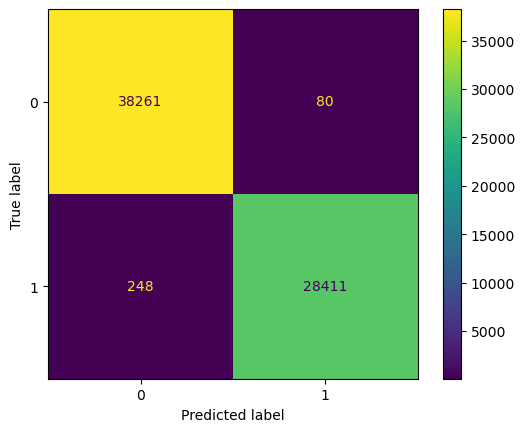

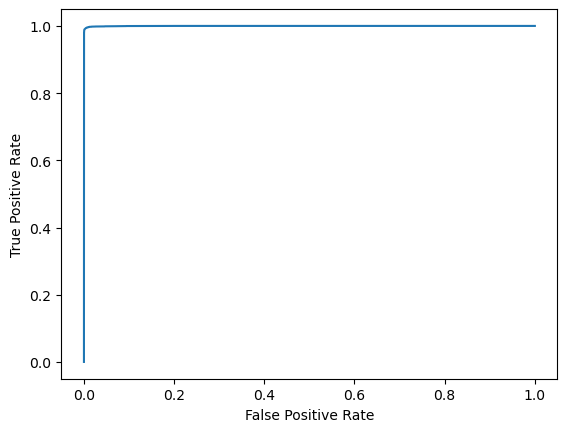

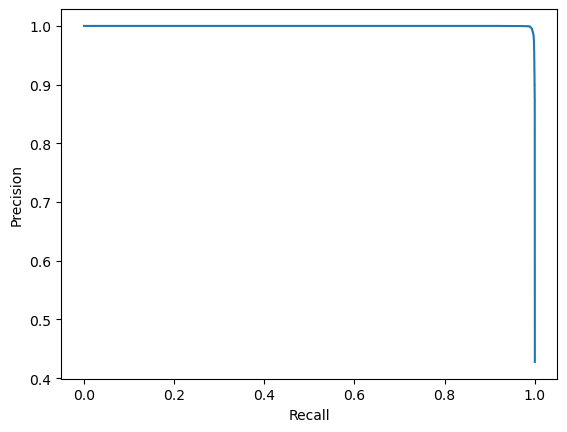

In [36]:
for k in train_plots:
    f = train_plots[k]
    f.plot()

In [37]:
valid_metrics, valid_plots = eval_model(model, X_valid, y_valid)
print("Validation metrics:")
print(valid_metrics)

Validation metrics:
{'roc_auc': 0.8055261955694886, 'average_precision': 0.7439625532805295, 'accuracy': 0.7357575757575757, 'precision': 0.6922802765699623, 'recall': 0.6880623450230251, 'f1': 0.6901648664013644, 'cm': array([[14568,  4317],
       [ 4403,  9712]])}


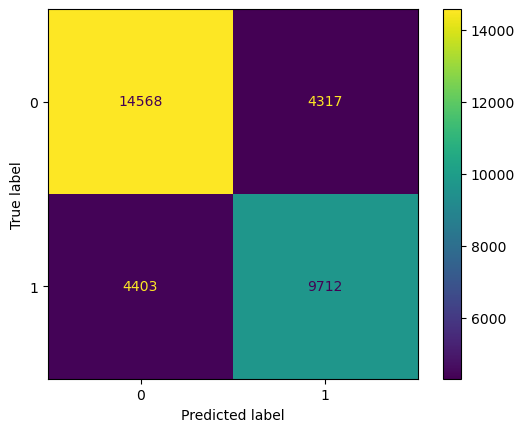

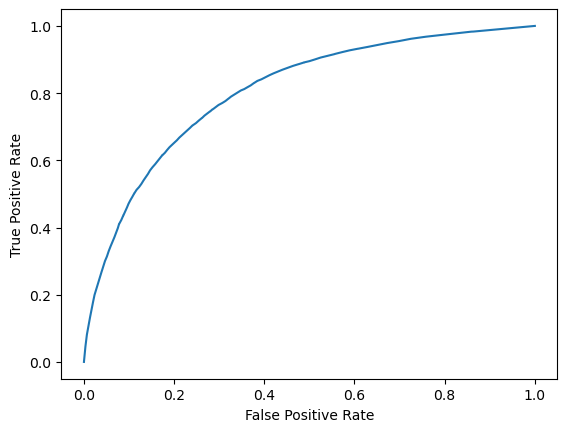

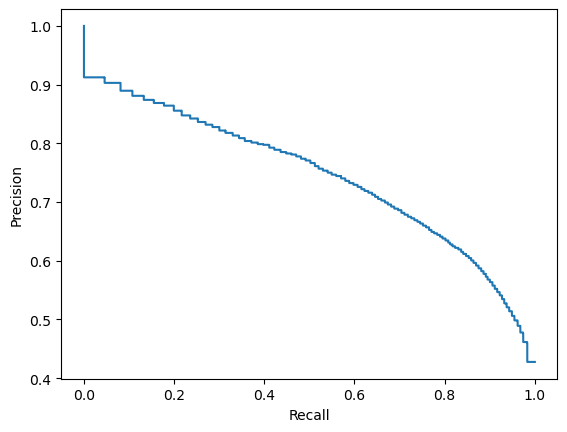

In [38]:
for k in valid_plots:
    f = valid_plots[k]
    f.plot()

### Training a Model with Hyper-parameters

In [39]:
import uuid

In [40]:
max_depths_list = [1, 5, 8, 10, 12, 15, 20, None]
train_metrics_list = []
valid_metrics_list = []
train_plots_list = []
valid_plots_list = []
models_list = []
for max_depth in max_depths_list:
    run_id = uuid.uuid4()
    
    print(f"Training Model {max_depth}")
    model = fit_model_rf(X_train, y_train, max_depth=max_depth)
    
    print("Evaluating Model")
    
    train_metrics, train_plots = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_metrics)
    train_metrics['data'] = 'train'
    train_metrics['n_est'] = 200
    train_metrics['max_depth'] = max_depth
    train_metrics['run_id'] = run_id
    train_metrics_list.append(train_metrics)
    train_plots_list.append(train_plots)
    
    valid_metrics, valid_plots = eval_model(model, X_valid, y_valid)
    print("Validation metrics:")
    print(valid_metrics)
    valid_metrics['data'] = 'valid'
    valid_metrics['n_est'] = 200
    valid_metrics['max_depth'] = max_depth
    valid_metrics['run_id'] = run_id
    valid_metrics_list.append(valid_metrics)
    valid_plots_list.append(valid_plots)
    
    models_list.append(model)
    print('----------------------')

Training Model 1
Evaluating Model
Train metrics:
{'roc_auc': 0.8277322689376897, 'average_precision': 0.7460946680817672, 'accuracy': 0.7421641791044776, 'precision': 0.7795952451124865, 'recall': 0.5537876408807006, 'f1': 0.647571250790542, 'cm': array([[33854,  4487],
       [12788, 15871]])}
Validation metrics:
{'roc_auc': 0.8300394026863004, 'average_precision': 0.7472810462807693, 'accuracy': 0.740909090909091, 'precision': 0.7766729641046037, 'recall': 0.5533829259652852, 'f1': 0.646284957802416, 'cm': array([[16639,  2246],
       [ 6304,  7811]])}
----------------------
Training Model 5
Evaluating Model
Train metrics:
{'roc_auc': 0.8449916550489891, 'average_precision': 0.7965656859557828, 'accuracy': 0.7783582089552239, 'precision': 0.7563964499238739, 'recall': 0.7107365923444642, 'f1': 0.7328560120889399, 'cm': array([[31781,  6560],
       [ 8290, 20369]])}
Validation metrics:
{'roc_auc': 0.8460582711080762, 'average_precision': 0.7962821927529715, 'accuracy': 0.77648484848

In [41]:
valid_resudf = pd.DataFrame.from_records(valid_metrics_list).set_index('run_id')
valid_resudf

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,n_est,max_depth
run_id,,,,,,,,,,
d3f20a17-ef38-4a98-ad68-38bc7a0efedc,0.830039,0.747281,0.740909,0.776673,0.553383,0.646285,"[[16639, 2246], [6304, 7811]]",valid,200,1.0
e796b949-99b3-460a-a741-ce46f17fbf0f,0.846058,0.796282,0.776485,0.753785,0.709033,0.730724,"[[15616, 3269], [4107, 10008]]",valid,200,5.0
71f9080f-beb7-46f7-9e71-52dc5312d993,0.849206,0.801173,0.777848,0.756077,0.709529,0.732064,"[[15654, 3231], [4100, 10015]]",valid,200,8.0
8d79f014-c7a3-4040-91de-8fcf71c40387,0.849371,0.802581,0.778515,0.752635,0.718243,0.735037,"[[15553, 3332], [3977, 10138]]",valid,200,10.0
fcee5b8d-54b2-4a99-a2cf-47f6a89f3a59,0.848199,0.801169,0.777576,0.747209,0.725399,0.736142,"[[15421, 3464], [3876, 10239]]",valid,200,12.0
ff573b83-cd1c-48c9-9fbf-aa6c82ab8abb,0.844115,0.796672,0.773212,0.741075,0.722069,0.731448,"[[15324, 3561], [3923, 10192]]",valid,200,15.0
dc4aa20d-272c-41ab-a308-87768ba6a61b,0.830294,0.777149,0.762848,0.729676,0.707758,0.718550,"[[15184, 3701], [4125, 9990]]",valid,200,20.0
4f3bc54f-b901-48e0-808f-caed7260e0f1,0.805526,0.743963,0.735758,0.692280,0.688062,0.690165,"[[14568, 4317], [4403, 9712]]",valid,200,NaN


## Best Model and Inference

In [42]:
valid_resudf.sort_values('f1')

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,n_est,max_depth
run_id,,,,,,,,,,
d3f20a17-ef38-4a98-ad68-38bc7a0efedc,0.830039,0.747281,0.740909,0.776673,0.553383,0.646285,"[[16639, 2246], [6304, 7811]]",valid,200,1.0
4f3bc54f-b901-48e0-808f-caed7260e0f1,0.805526,0.743963,0.735758,0.692280,0.688062,0.690165,"[[14568, 4317], [4403, 9712]]",valid,200,NaN
dc4aa20d-272c-41ab-a308-87768ba6a61b,0.830294,0.777149,0.762848,0.729676,0.707758,0.718550,"[[15184, 3701], [4125, 9990]]",valid,200,20.0
e796b949-99b3-460a-a741-ce46f17fbf0f,0.846058,0.796282,0.776485,0.753785,0.709033,0.730724,"[[15616, 3269], [4107, 10008]]",valid,200,5.0
ff573b83-cd1c-48c9-9fbf-aa6c82ab8abb,0.844115,0.796672,0.773212,0.741075,0.722069,0.731448,"[[15324, 3561], [3923, 10192]]",valid,200,15.0
71f9080f-beb7-46f7-9e71-52dc5312d993,0.849206,0.801173,0.777848,0.756077,0.709529,0.732064,"[[15654, 3231], [4100, 10015]]",valid,200,8.0
8d79f014-c7a3-4040-91de-8fcf71c40387,0.849371,0.802581,0.778515,0.752635,0.718243,0.735037,"[[15553, 3332], [3977, 10138]]",valid,200,10.0
fcee5b8d-54b2-4a99-a2cf-47f6a89f3a59,0.848199,0.801169,0.777576,0.747209,0.725399,0.736142,"[[15421, 3464], [3876, 10239]]",valid,200,12.0


In [43]:
best_max_depth = valid_resudf.sort_values('f1').iloc[-1].max_depth
best_index = max_depths_list.index(best_max_depth)
best_index

4

In [44]:
models_list[best_index].predict(inputX.reshape(1,-1))

/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [45]:
models_list[best_index].predict(X_valid)

array([0, 1, 0, ..., 0, 0, 1])